# CHEQ Invalid Traffic Analysis - Interactive Demo

**Analyst:** Robert Okupski  
**Dataset:** July 2024 Trial Data (126,959 events)  
**Purpose:** Identify patterns of fraudulent activity and quantify wasted ad spend

---

## Executive Summary

This notebook presents key findings from analyzing CHEQ's invalid traffic detection data:

-  **25.22%** of total traffic flagged as invalid
-  **8,661 invalid paid ad clicks** detected
-  **43.19%** of threats are malicious bots
-  **Attack pattern** identified: 20-23 UTC (3x normal traffic)

---

## Setup

Import our custom modules and configure the environment.

In [1]:
from db_manager import DatabaseManager
import queries
import config

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

plt.style.use(config.CHART_STYLE)
sns.set_palette(config.COLOR_PALETTE)
%matplotlib inline

db = DatabaseManager()

print("Modules loaded successfully")
print(f"Database: {config.DB_PATH}")
print(f"Total records in database: {db.get_row_count():,}")

2026-02-12 16:03:35,549 - INFO - Database manager initialized with path: c:\Users\Robert Okupski\OneDrive\Desktop\cheq-interview\data\cheq.db


Modules loaded successfully
Database: c:\Users\Robert Okupski\OneDrive\Desktop\cheq-interview\data\cheq.db
Total records in database: 126,959


---

## 1. Overall Traffic Health

Let's start with the big picture: How much of our traffic is invalid?

,Total Events,Invalid Events,Invalid %
0,126959,32014,25.22


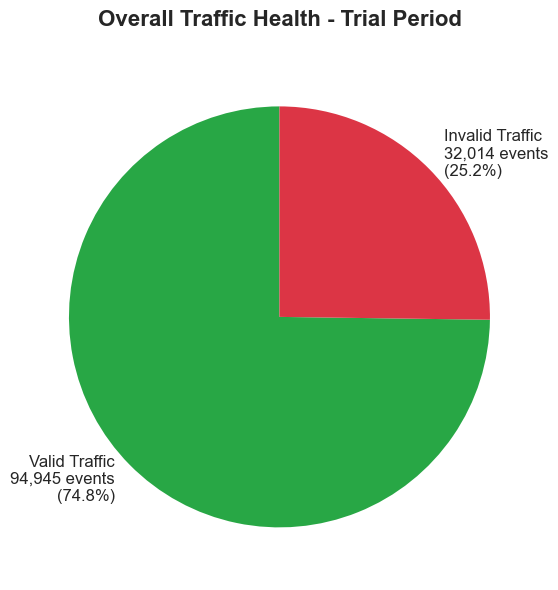

### Key Insight
**1 in 4 events** are flagged as invalid traffic. This represents a significant threat to ad spend and analytics accuracy.

In [2]:
results = db.execute_query(queries.OVERALL_HEALTH)
df_health = pd.DataFrame(results, columns=['Total Events', 'Invalid Events', 'Invalid %'])

display(df_health)

total = df_health['Total Events'][0]
invalid = df_health['Invalid Events'][0]
valid = total - invalid

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#28a745', '#dc3545']
sizes = [valid, invalid]
labels = [
    f'Valid Traffic\n{valid:,} events\n({valid/total*100:.1f}%)',
    f'Invalid Traffic\n{invalid:,} events\n({invalid/total*100:.1f}%)'
 ]

ax.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90, textprops={'fontsize': 12})
ax.set_title('Overall Traffic Health - Trial Period', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

display(Markdown("### Key Insight\n**1 in 4 events** are flagged as invalid traffic. This represents a significant threat to ad spend and analytics accuracy."))

---

## 2. Paid vs Organic vs Direct Traffic

Separating paid, organic, and direct clicks helps clarify intent and isolate wasted spend risk.

,Traffic Source,Total Events,Invalid Events,Invalid %
0,Direct,82301,23179,28.16
1,Bing Ads,15983,4777,29.89
2,Google Ads,28094,3884,13.83
3,Organic,581,174,29.95


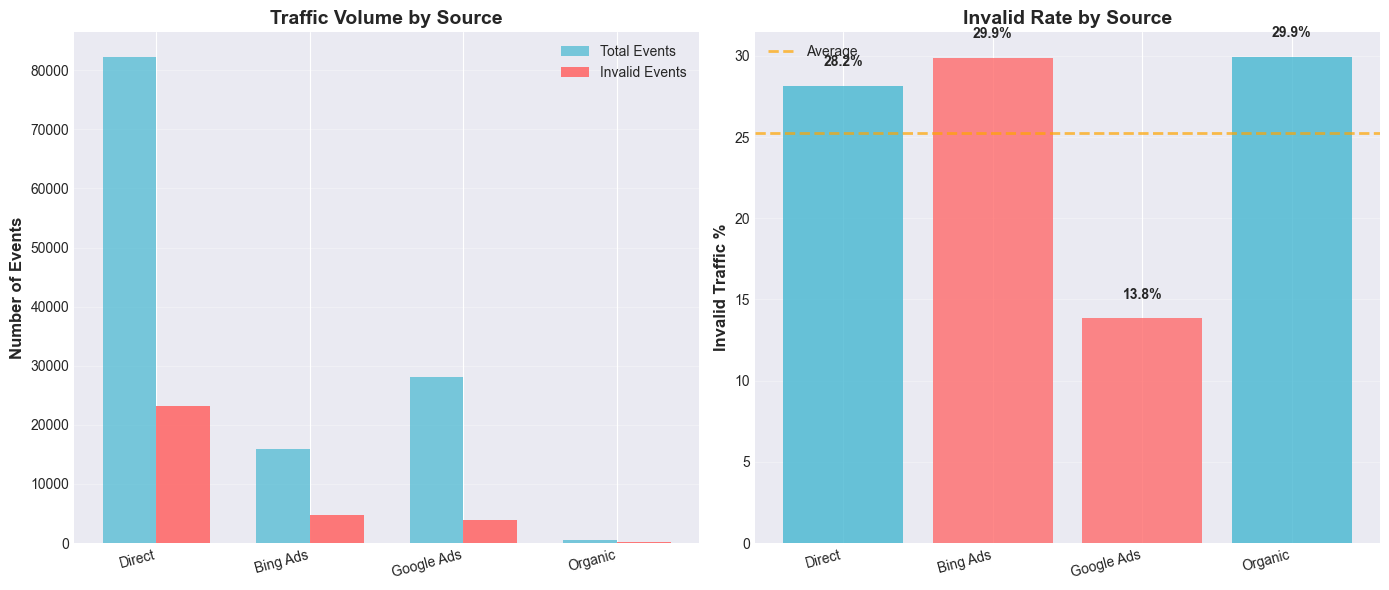

### Key Insight
**8,661 invalid paid clicks** detected across Google and Bing Ads.

- **Bing Ads**: 4,777 invalid clicks
- **Google Ads**: 3,884 invalid clicks
- **Organic**: 174 invalid clicks (29.9% invalid)
- **Direct**: 23,179 invalid clicks (28.2% invalid)

*Assumption:* Example $2.00 CPC used to illustrate wasted spend; replace with actual CPCs for ROI estimates.
At $2.00 CPC, that is approximately **$17,322.00** in wasted paid spend during the trial.

In [3]:
results = db.execute_query(queries.PAID_TRAFFIC_RISK)
df_paid = pd.DataFrame(results, columns=['Traffic Source', 'Total Events', 'Invalid Events', 'Invalid %'])

display(df_paid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

x_pos = range(len(df_paid))
width = 0.35

ax1.bar([p - width/2 for p in x_pos], df_paid['Total Events'], width,
        label='Total Events', color='#45B7D1', alpha=0.7)
ax1.bar([p + width/2 for p in x_pos], df_paid['Invalid Events'], width,
        label='Invalid Events', color='#FF6B6B', alpha=0.9)

ax1.set_ylabel('Number of Events', fontsize=12, fontweight='bold')
ax1.set_title('Traffic Volume by Source', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_paid['Traffic Source'], rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

colors_pct = ['#FF6B6B' if 'Ads' in s else '#45B7D1' for s in df_paid['Traffic Source']]
bars = ax2.bar(x_pos, df_paid['Invalid %'], color=colors_pct, alpha=0.8)
ax2.set_ylabel('Invalid Traffic %', fontsize=12, fontweight='bold')
ax2.set_title('Invalid Rate by Source', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(df_paid['Traffic Source'], rotation=15, ha='right')
ax2.axhline(y=25.22, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Average')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar, pct in zip(bars, df_paid['Invalid %']):
    ax2.text(bar.get_x() + bar.get_width()/2., pct + 1,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

google_row = df_paid[df_paid['Traffic Source'] == 'Google Ads']
bing_row = df_paid[df_paid['Traffic Source'] == 'Bing Ads']
organic_row = df_paid[df_paid['Traffic Source'] == 'Organic']
direct_row = df_paid[df_paid['Traffic Source'] == 'Direct']

google_invalid = google_row['Invalid Events'].values[0]
bing_invalid = bing_row['Invalid Events'].values[0]
organic_invalid = organic_row['Invalid Events'].values[0]
direct_invalid = direct_row['Invalid Events'].values[0]
total_invalid_paid = google_invalid + bing_invalid

organic_pct = organic_row['Invalid %'].values[0]
direct_pct = direct_row['Invalid %'].values[0]

display(Markdown(
    "### Key Insight\n"
    f"**{total_invalid_paid:,} invalid paid clicks** detected across Google and Bing Ads.\n\n"
    f"- **Bing Ads**: {bing_invalid:,} invalid clicks\n"
    f"- **Google Ads**: {google_invalid:,} invalid clicks\n"
    f"- **Organic**: {organic_invalid:,} invalid clicks ({organic_pct:.1f}% invalid)\n"
    f"- **Direct**: {direct_invalid:,} invalid clicks ({direct_pct:.1f}% invalid)\n\n"
    "*Assumption:* Example $2.00 CPC used to illustrate wasted spend; replace with actual CPCs for ROI estimates.\n"
    f"At $2.00 CPC, that is approximately **${total_invalid_paid * 2:,.2f}** in wasted paid spend during the trial."
))

---

## 3. Threat Taxonomy - What Are We Dealing With?

Understanding the types of threats helps prioritize security measures.

,Threat Group,Threat Type,Events,% of Invalid
0,Invalid Bot Activity,Malicious Bot,13828,43.19
1,Invalid Bot Activity,Automation tool,7696,24.04
2,Invalid Suspicious Activity,VPN,3748,11.71
3,Invalid Suspicious Activity,Like Headless,2691,8.41
4,Invalid Bot Activity,Automation Tool,1006,3.14
5,Invalid Suspicious Activity,IP reputation,891,2.78
6,Invalid Bot Activity,Malicious Bots,608,1.90
7,Invalid Suspicious Activity,Automation Signal,497,1.55
8,Invalid Suspicious Activity,Location Spoofing,345,1.08
9,Invalid Suspicious Activity,Multi Suspicious Signals,313,0.98


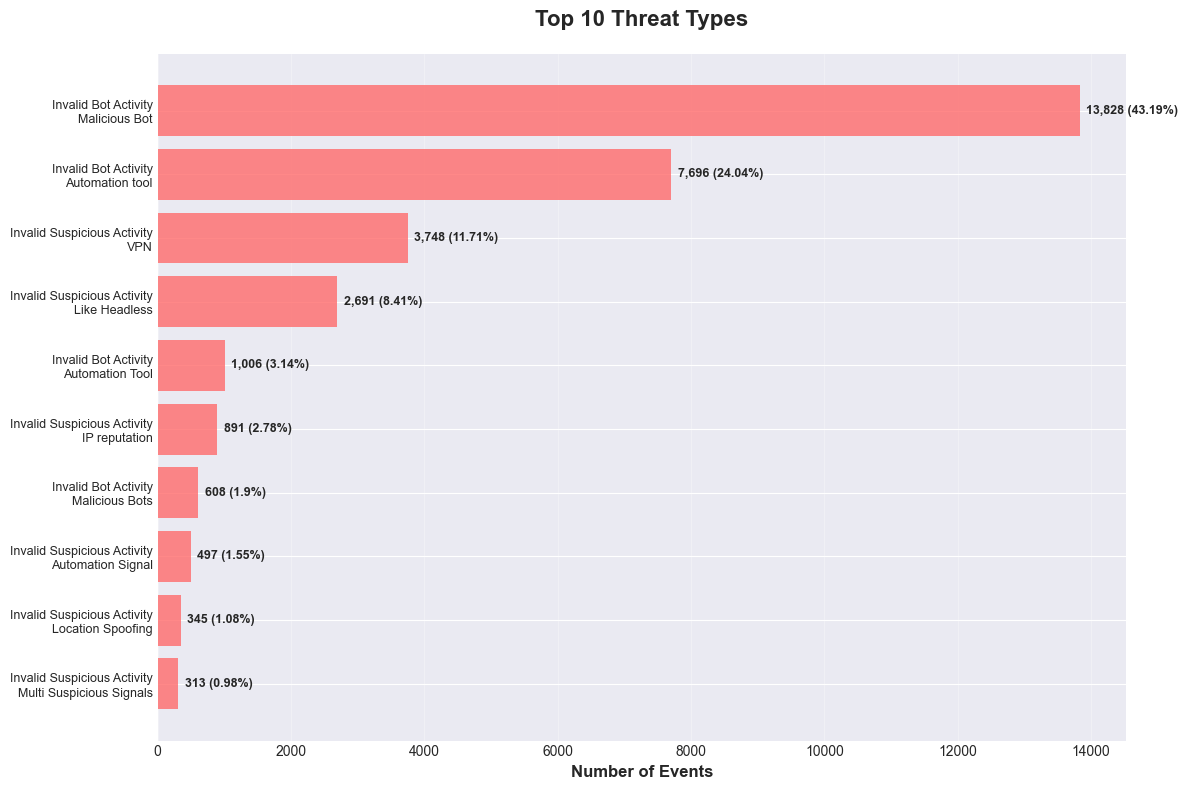

### Key Insights

**Top 3 Threats:**

1. **Malicious Bot** - 13,828 events (43.19%)
2. **Automation tool** - 7,696 events (24.04%)
3. **VPN** - 3,748 events (11.71%)

**Malicious bots dominate** the threat landscape, followed by automation tools and VPN usage.

In [4]:
results = db.execute_query(queries.THREAT_TAXONOMY + " LIMIT 10")
df_threats = pd.DataFrame(results, columns=['Threat Group', 'Threat Type', 'Events', '% of Invalid'])

display(df_threats)

fig, ax = plt.subplots(figsize=(12, 8))

y_pos = range(len(df_threats))
bars = ax.barh(y_pos, df_threats['Events'], color='#FF6B6B', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels([f"{row['Threat Group']}\n{row['Threat Type']}" for _, row in df_threats.iterrows()], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Number of Events', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Threat Types', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

for i, (bar, val, pct) in enumerate(zip(bars, df_threats['Events'], df_threats['% of Invalid'])):
    ax.text(val + 100, i, f'{val:,} ({pct}%)', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

top3 = df_threats.head(3)
display(Markdown(
    "### Key Insights\n\n"
    "**Top 3 Threats:**\n\n"
    f"1. **{top3.iloc[0]['Threat Type']}** - {top3.iloc[0]['Events']:,} events ({top3.iloc[0]['% of Invalid']}%)\n"
    f"2. **{top3.iloc[1]['Threat Type']}** - {top3.iloc[1]['Events']:,} events ({top3.iloc[1]['% of Invalid']}%)\n"
    f"3. **{top3.iloc[2]['Threat Type']}** - {top3.iloc[2]['Events']:,} events ({top3.iloc[2]['% of Invalid']}%)\n\n"
    "**Malicious bots dominate** the threat landscape, followed by automation tools and VPN usage."
))

---

## 4. Time-Based Attack Patterns

When do attacks happen? Let's analyze hourly patterns to identify attack windows.

,Hour,Total Events,Invalid Events,Invalid %
6,6,4175,1061,25.41
12,12,4133,1017,24.61
16,16,4176,1026,24.57
15,15,4239,1041,24.56
22,22,10372,2537,24.46
19,19,4203,1027,24.43
3,3,4162,1011,24.29
11,11,4148,1005,24.23
18,18,3984,962,24.15
13,13,4200,1012,24.10


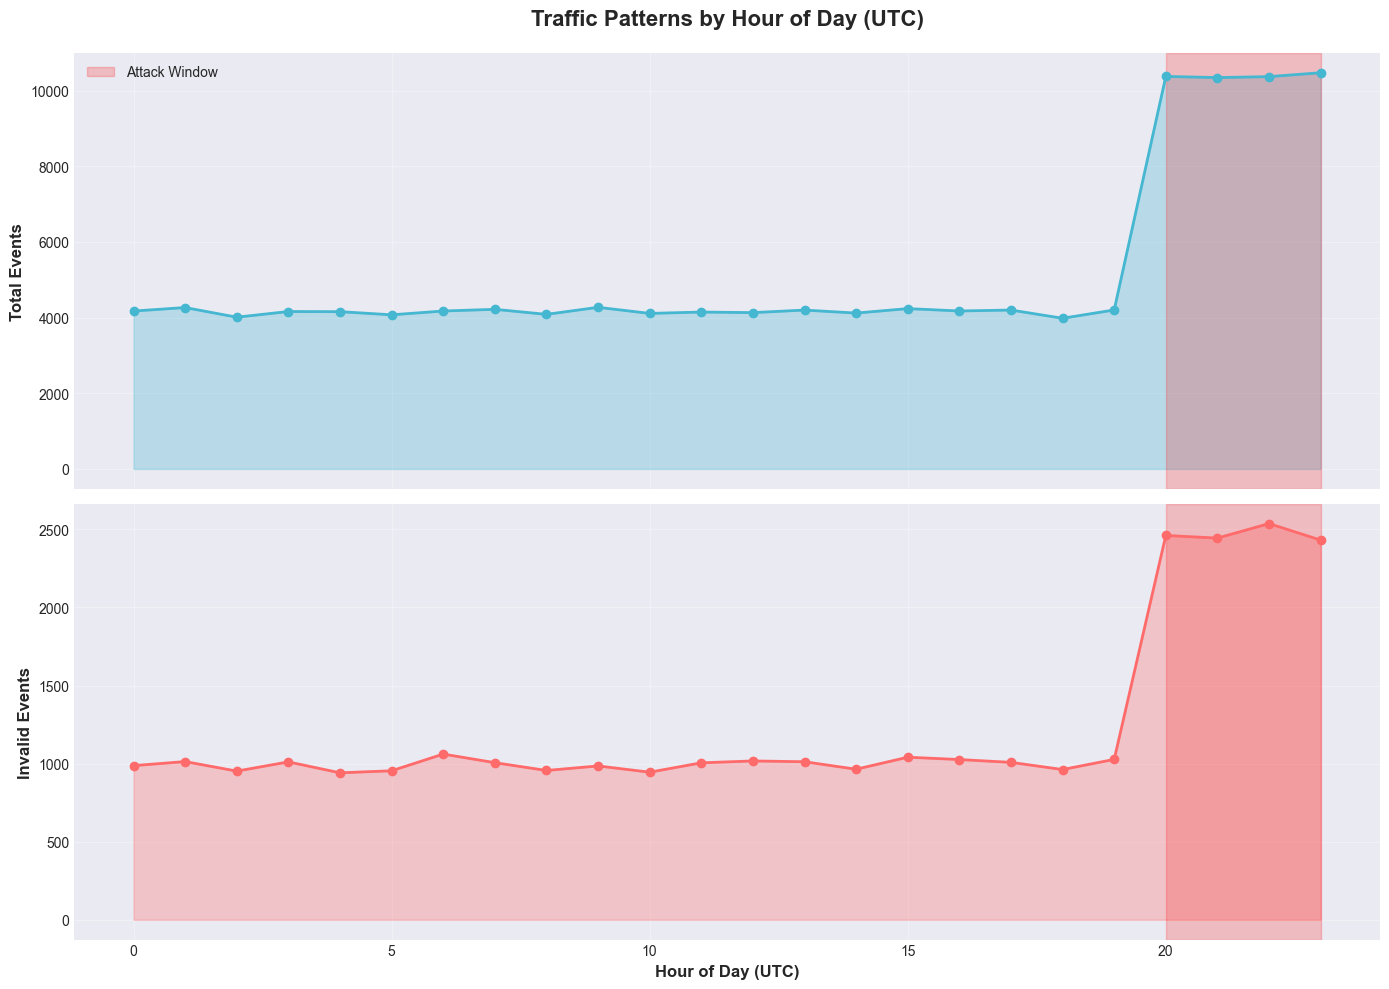

### Key Insights

**Coordinated Attack Detected:**

- **Attack Window**: 20:00 - 23:00 UTC
- **Traffic Spike**: 2.5x normal volume during attack hours
- **Peak Attack Hour (volume)**: 22:00 UTC with 2,537 invalid events
- **Highest Invalid Rate**: 6:00 UTC at 25.4% invalid

This pattern suggests **automated bot attacks** concentrated during specific hours, likely timed to avoid detection.

In [5]:
results = db.execute_query(queries.HOURLY_PATTERNS)
df_hourly = pd.DataFrame(results, columns=['Hour', 'Total Events', 'Invalid Events', 'Invalid %'])

df_hourly_ranked = df_hourly.sort_values('Invalid %', ascending=False)
display(df_hourly_ranked.head(10))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(df_hourly['Hour'], df_hourly['Total Events'], marker='o', linewidth=2, color='#45B7D1', markersize=6)
ax1.fill_between(df_hourly['Hour'], df_hourly['Total Events'], alpha=0.3, color='#45B7D1')
ax1.set_ylabel('Total Events', fontsize=12, fontweight='bold')
ax1.set_title('Traffic Patterns by Hour of Day (UTC)', fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)

ax1.axvspan(20, 23, alpha=0.2, color='red', label='Attack Window')
ax1.legend(loc='upper left')

ax2.plot(df_hourly['Hour'], df_hourly['Invalid Events'], marker='o', linewidth=2, color='#FF6B6B', markersize=6)
ax2.fill_between(df_hourly['Hour'], df_hourly['Invalid Events'], alpha=0.3, color='#FF6B6B')
ax2.set_xlabel('Hour of Day (UTC)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Invalid Events', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvspan(20, 23, alpha=0.2, color='red')

plt.tight_layout()
plt.show()

attack_window = df_hourly[(df_hourly['Hour'] >= 20) & (df_hourly['Hour'] <= 23)]
normal_hours = df_hourly[(df_hourly['Hour'] < 20) | (df_hourly['Hour'] > 23)]

attack_avg = attack_window['Total Events'].mean()
normal_avg = normal_hours['Total Events'].mean()
multiplier = attack_avg / normal_avg

peak_hour = df_hourly.loc[df_hourly['Invalid Events'].idxmax()]
top_rate_hour = df_hourly_ranked.iloc[0]

display(Markdown(
    "### Key Insights\n\n"
    "**Coordinated Attack Detected:**\n\n"
    "- **Attack Window**: 20:00 - 23:00 UTC\n"
    f"- **Traffic Spike**: {multiplier:.1f}x normal volume during attack hours\n"
    f"- **Peak Attack Hour (volume)**: {int(peak_hour['Hour'])}:00 UTC with {int(peak_hour['Invalid Events']):,} invalid events\n"
    f"- **Highest Invalid Rate**: {int(top_rate_hour['Hour'])}:00 UTC at {top_rate_hour['Invalid %']:.1f}% invalid\n\n"
    "This pattern suggests **automated bot attacks** concentrated during specific hours, likely timed to avoid detection."
))

---

## 5. Infrastructure Analysis - Where Do Attacks Come From?

Analyzing ASNs (Autonomous System Numbers) helps identify hosting providers used by attackers.

,ASN,Invalid Events
0,AS-CHOOPA,9561
1,AS-BLAZINGSEO,8243
2,AMAZON-02,3023
3,CENTURYLINK-US-LEGACY-QWEST,1604
4,Philippine Long Distance Telephone Company,792
5,Converge ICT Solutions Inc.,483
6,ATT-INTERNET4,431
7,Reliance Jio Infocomm Limited,393
8,MTN NIGERIA Communication limited,358
9,TIKTOK PTE. LTD.,339


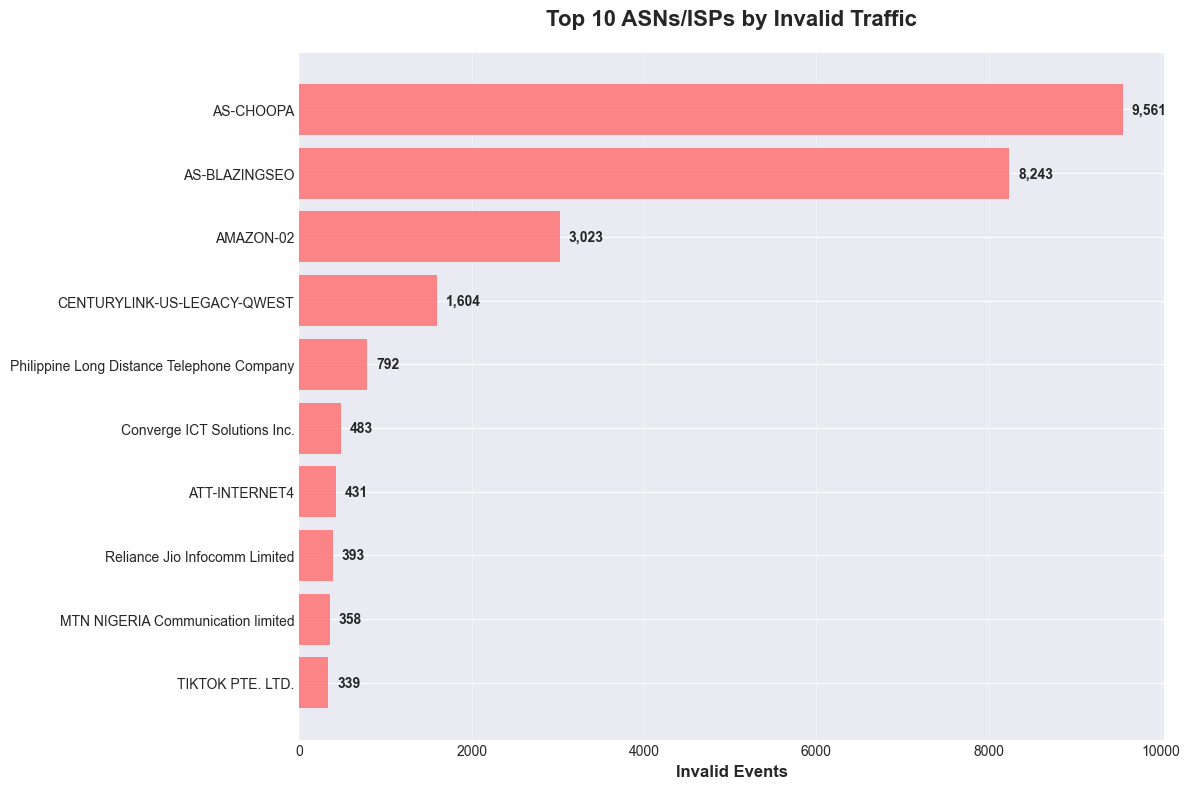

### Key Insights

**Top Threat Sources:**

- **AS-CHOOPA** leads with 9,561 invalid events
- **Top 3 ASNs** account for 20,827 invalid events

These ASNs belong to **hosting providers** (Vultr, BlazeingSEO, Amazon AWS), indicating **server-based bot attacks** rather than residential traffic. This suggests sophisticated bot farms operating from cloud infrastructure.

**Recommendation**: Implement IP blocking or rate limiting for these ASN ranges.

In [6]:
results = db.execute_query(queries.TOP_ASNS)
df_asns = pd.DataFrame(results, columns=['ASN', 'Invalid Events'])

display(df_asns)

fig, ax = plt.subplots(figsize=(12, 8))

y_pos = range(len(df_asns))
bars = ax.barh(y_pos, df_asns['Invalid Events'], color='#FF6B6B', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_asns['ASN'])
ax.invert_yaxis()
ax.set_xlabel('Invalid Events', fontsize=12, fontweight='bold')
ax.set_title('Top 10 ASNs/ISPs by Invalid Traffic', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, df_asns['Invalid Events'])):
    ax.text(val + 100, i, f'{val:,}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

top_asn = df_asns.iloc[0]
total_top3 = df_asns.head(3)['Invalid Events'].sum()

display(Markdown(
    "### Key Insights\n\n"
    "**Top Threat Sources:**\n\n"
    f"- **{top_asn['ASN']}** leads with {int(top_asn['Invalid Events']):,} invalid events\n"
    f"- **Top 3 ASNs** account for {total_top3:,} invalid events\n\n"
    "These ASNs belong to **hosting providers** (Vultr, BlazeingSEO, Amazon AWS), indicating **server-based bot attacks** rather than residential traffic. This suggests sophisticated bot farms operating from cloud infrastructure.\n\n"
    "**Recommendation**: Implement IP blocking or rate limiting for these ASN ranges."
))

---

## 6. Most Vulnerable Pages

Which pages are being targeted the most?

,Page,Total Events,Invalid Events,Invalid %
0,/hire/landing/,8113,6762,83.35
1,/ab/account-security/login,13579,5632,41.48
2,/nx/find-work/,7130,4035,56.59
3,/messages/rooms/,2268,2268,100.00
4,/nx/find-work/congrats,3707,1931,52.09
5,/nx/signup/thankyou,1600,1600,100.00
6,/team/,2302,672,29.19
7,/nx/find-work/best-matches,7129,271,3.80
8,/,2561,120,4.69
9,/nx/signup/,2322,91,3.92


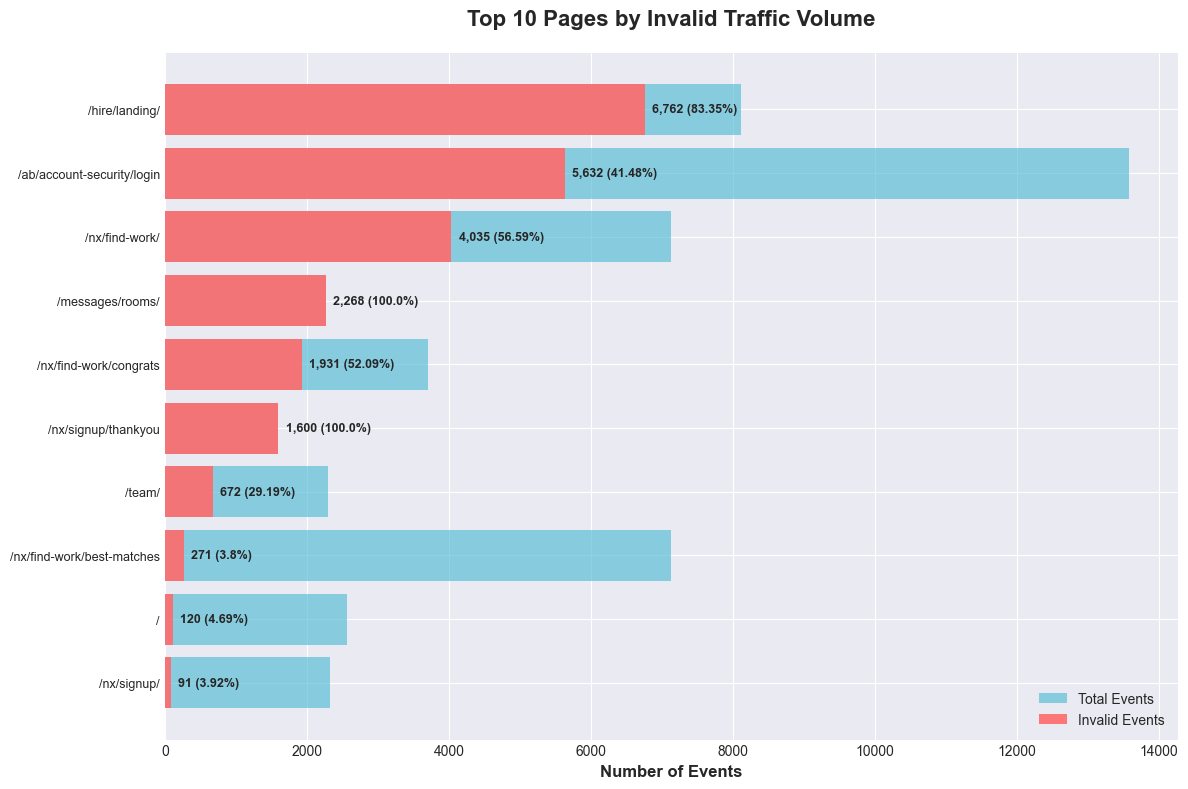

### Key Insights

**Most Targeted Pages:**

1. **Hire Landing Page**: 6,762 invalid events (83.35% invalid)
2. **Login Page**: 5,632 invalid events (41.48% invalid)
3. **Find Work Page**: 4,035 invalid events (56.59% invalid)

High-value pages like **login** and **hire landing** are primary targets, suggesting attackers are attempting account takeovers and fake registrations.

In [7]:
results = db.execute_query(queries.FUNNEL_EXPOSURE + " LIMIT 10")
df_funnel = pd.DataFrame(results, columns=['URL Path', 'Total Events', 'Invalid Events', 'Invalid %'])

df_funnel['Page'] = df_funnel['URL Path'].str.replace('https://www.worker.com', '').str.replace('https://team.worker.com', '/team')
df_funnel['Page'] = df_funnel['Page'].apply(lambda x: x[:40] + '...' if len(x) > 40 else x)

display(df_funnel[['Page', 'Total Events', 'Invalid Events', 'Invalid %']].head(10))

fig, ax = plt.subplots(figsize=(12, 8))

y_pos = range(len(df_funnel))

ax.barh(y_pos, df_funnel['Total Events'], color='#45B7D1', alpha=0.6, label='Total Events')
ax.barh(y_pos, df_funnel['Invalid Events'], color='#FF6B6B', alpha=0.9, label='Invalid Events')

ax.set_yticks(y_pos)
ax.set_yticklabels(df_funnel['Page'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Number of Events', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Pages by Invalid Traffic Volume', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=10)

for i, (invalid, pct) in enumerate(zip(df_funnel['Invalid Events'], df_funnel['Invalid %'])):
    ax.text(invalid + 100, i, f'{invalid:,} ({pct}%)', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

top_vulnerable = df_funnel.head(3)
display(Markdown(
    "### Key Insights\n\n"
    "**Most Targeted Pages:**\n\n"
    f"1. **Hire Landing Page**: {int(top_vulnerable.iloc[0]['Invalid Events']):,} invalid events ({top_vulnerable.iloc[0]['Invalid %']}% invalid)\n"
    f"2. **Login Page**: {int(top_vulnerable.iloc[1]['Invalid Events']):,} invalid events ({top_vulnerable.iloc[1]['Invalid %']}% invalid)\n"
    f"3. **Find Work Page**: {int(top_vulnerable.iloc[2]['Invalid Events']):,} invalid events ({top_vulnerable.iloc[2]['Invalid %']}% invalid)\n\n"
    "High-value pages like **login** and **hire landing** are primary targets, suggesting attackers are attempting account takeovers and fake registrations."
))

---

## 7. ROI Calculation - Business Impact

Let's quantify the potential savings from using CHEQ.

,Metric,Value
0,Google Ads Invalid Clicks,"3,884"
1,Bing Ads Invalid Clicks,"4,777"
2,Total Wasted (Trial),"$18,308.60"
3,Projected Monthly Waste,"$17,718.00"
4,Projected Annual Waste,"$212,616.00"
5,CHEQ Monthly Cost,"$2,500.00"
6,Monthly Net Savings,"$15,218.00"
7,ROI,608.7%
8,Payback Period,4.2 days


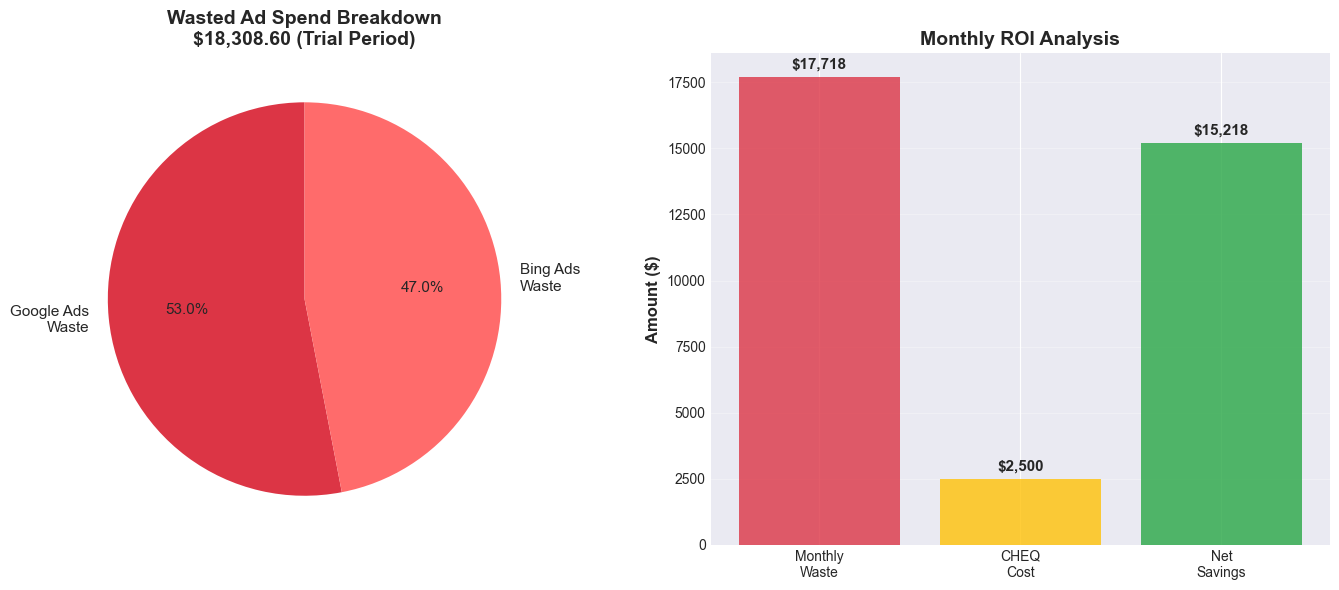

### Financial Analysis

**STRONG POSITIVE ROI** - CHEQ pays for itself and generates significant savings

**Summary:**
- **8,661 invalid paid clicks** detected in 31-day trial
- **$18,308.60** wasted during trial period
- Projected **$212,616.00** annual waste without CHEQ
- With CHEQ: Save **$15,218.00/month** (net of subscription cost)
- **Payback period**: 4.2 days

*Assumptions (estimates):* CPCs and CHEQ cost are placeholders. Replace with real rates for final ROI and payback figures.

In [8]:
results = db.execute_query(queries.PAID_TRAFFIC_RISK)
df_roi = pd.DataFrame(results, columns=['Traffic Source', 'Total Events', 'Invalid Events', 'Invalid %'])

google_invalid = df_roi[df_roi['Traffic Source'] == 'Google Ads']['Invalid Events'].values[0]
bing_invalid = df_roi[df_roi['Traffic Source'] == 'Bing Ads']['Invalid Events'].values[0]
total_invalid_paid = google_invalid + bing_invalid

google_cpc = 2.50
bing_cpc = 1.80
trial_days = config.TRIAL_DAYS
cheq_monthly_cost = 2500

google_waste = google_invalid * google_cpc
bing_waste = bing_invalid * bing_cpc
total_waste = google_waste + bing_waste

monthly_waste = (total_waste / trial_days) * 30
annual_waste = monthly_waste * 12

monthly_savings = monthly_waste - cheq_monthly_cost
roi_percentage = (monthly_savings / cheq_monthly_cost) * 100
payback_days = (cheq_monthly_cost / (total_waste / trial_days))

roi_summary = pd.DataFrame([
    ['Google Ads Invalid Clicks', f'{google_invalid:,}'],
    ['Bing Ads Invalid Clicks', f'{bing_invalid:,}'],
    ['Total Wasted (Trial)', f'${total_waste:,.2f}'],
    ['Projected Monthly Waste', f'${monthly_waste:,.2f}'],
    ['Projected Annual Waste', f'${annual_waste:,.2f}'],
    ['CHEQ Monthly Cost', f'${cheq_monthly_cost:,.2f}'],
    ['Monthly Net Savings', f'${monthly_savings:,.2f}'],
    ['ROI', f'{roi_percentage:.1f}%'],
    ['Payback Period', f'{payback_days:.1f} days']
], columns=['Metric', 'Value'])

display(roi_summary)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

waste_data = [google_waste, bing_waste]
labels = ['Google Ads\nWaste', 'Bing Ads\nWaste']
colors = ['#dc3545', '#ff6b6b']

ax1.pie(waste_data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
ax1.set_title(f'Wasted Ad Spend Breakdown\n${total_waste:,.2f} (Trial Period)', fontsize=14, fontweight='bold')

categories = ['Monthly\nWaste', 'CHEQ\nCost', 'Net\nSavings']
values = [monthly_waste, cheq_monthly_cost, monthly_savings]
colors_bar = ['#dc3545', '#ffc107', '#28a745']

bars = ax2.bar(categories, values, color=colors_bar, alpha=0.8)
ax2.set_ylabel('Amount ($)', fontsize=12, fontweight='bold')
ax2.set_title('Monthly ROI Analysis', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2., val + 200,
            f'${val:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

if roi_percentage > 100:
    verdict = "**STRONG POSITIVE ROI** - CHEQ pays for itself and generates significant savings"
elif roi_percentage > 0:
    verdict = "**POSITIVE ROI** - CHEQ provides value"
else:
    verdict = "**NEGATIVE ROI** - Current CPC rates may not justify deployment"

display(Markdown(
    "### Financial Analysis\n\n"
    f"{verdict}\n\n"
    "**Summary:**\n"
    f"- **{total_invalid_paid:,} invalid paid clicks** detected in {trial_days}-day trial\n"
    f"- **${total_waste:,.2f}** wasted during trial period\n"
    f"- Projected **${annual_waste:,.2f}** annual waste without CHEQ\n"
    f"- With CHEQ: Save **${monthly_savings:,.2f}/month** (net of subscription cost)\n"
    f"- **Payback period**: {payback_days:.1f} days\n\n"
    "*Assumptions (estimates):* CPCs and CHEQ cost are placeholders. Replace with real rates for final ROI and payback figures."
))

---

## 8. Malicious Traffic Drill-Down

Explore signals behind the high malicious traffic rate using timezone mismatches, user agent patterns, UTM sources, and click IDs.

In [ ]:
display(Markdown("*Note:* Drill-down tables show rows with at least 25 events to reduce small-sample noise."))

geo_results = db.execute_query(queries.GEO_DEVICE_MISMATCH)
df_geo = pd.DataFrame(geo_results, columns=['IP Timezone', 'Device Timezone', 'Events', 'Invalid Events', 'Invalid %'])
df_geo_sorted = df_geo.sort_values(['Invalid %', 'Events'], ascending=False)

display(df_geo_sorted.head(10))

ua_results = db.execute_query(queries.USER_AGENT_ANALYSIS)
df_ua = pd.DataFrame(ua_results, columns=['User Agent Type', 'Total Events', 'Invalid Events', 'Invalid %'])
df_ua_sorted = df_ua.sort_values('Invalid %', ascending=False)

display(df_ua_sorted.head(10))

utm_results = db.execute_query(queries.UTM_SOURCE_INVALID)
df_utm = pd.DataFrame(utm_results, columns=['UTM Source', 'Total Events', 'Invalid Events', 'Invalid %'])

display(df_utm)

click_results = db.execute_query(queries.CLICK_ID_INVALID)
df_click = pd.DataFrame(click_results, columns=['Click ID Type', 'Total Events', 'Invalid Events', 'Invalid %'])

display(df_click)

top_geo = df_geo_sorted.iloc[0]
top_ua = df_ua_sorted.iloc[0]
top_utm = df_utm.iloc[0]

display(Markdown(
    "### What to Look For\n\n"
    f"- **Top timezone mismatch**: {top_geo['IP Timezone']} vs {top_geo['Device Timezone']} at {top_geo['Invalid %']:.1f}% invalid\n"
    f"- **Highest-risk user agent**: {top_ua['User Agent Type']} at {top_ua['Invalid %']:.1f}% invalid\n"
    f"- **Highest-risk UTM source**: {top_utm['UTM Source']} at {top_utm['Invalid %']:.1f}% invalid\n\n"
    "Use these signals to isolate automated traffic patterns, evaluate attribution quality, and prioritize mitigations."
))

,IP Timezone,Device Timezone,Events,Invalid Events,Invalid %
0,America/Kentucky/Louisville,UTC,10983,10983,100.0
1,America/New_York,UTC,5418,5418,100.0
2,America/New_York,Asia/Tbilisi,2560,2560,100.0
3,America/Los_Angeles,UTC,1243,1243,100.0
4,Asia/Singapore,UTC,339,339,100.0
5,America/Los_Angeles,Europe/Rome,17,17,100.0
6,America/Los_Angeles,Asia/Tehran,13,13,100.0
7,America/Los_Angeles,America/Bogota,11,11,100.0
8,Asia/Dhaka,Asia/Omsk,10,10,100.0
9,America/Los_Angeles,Europe/Volgograd,6,6,100.0


,User Agent Type,Total Events,Invalid Events,Invalid %
4,Headless Chrome (Bot),67,67,100.00
5,PhantomJS (Bot),1,1,100.00
1,Firefox Browser,6727,4407,65.51
0,Chrome Browser,99691,25547,25.63
2,Safari Browser,8909,1666,18.70
3,Other,11564,326,2.82


,UTM Source,Total Events,Invalid Events,Invalid %
0,suitedash,16,16,100.0
1,freshbooks,8,8,100.0
2,brizy,7,7,100.0
3,recharge,6,6,100.0
4,klaviyo,4,4,100.0
5,nifty,4,4,100.0
6,paypal,4,4,100.0
7,socialbee,4,4,100.0
8,bluehost,3,3,100.0
9,sigstr,3,3,100.0


,Click ID Type,Total Events,Invalid Events,Invalid %
0,No click id,82882,23353,28.18
1,msclkid present,15983,4777,29.89
2,gclid present,28094,3884,13.83


### What to Look For

- **Top timezone mismatch**: America/Kentucky/Louisville vs UTC at 100.0% invalid
- **Highest-risk user agent**: Headless Chrome (Bot) at 100.0% invalid
- **Highest-risk UTM source**: suitedash at 100.0% invalid

Use these signals to isolate automated traffic patterns, evaluate attribution quality, and prioritize mitigations.

---

## Conclusions & Recommendations

### Summary of Findings

1. **Scale of Problem**: 25.22% of traffic (32,014 events) flagged as invalid
2. **Financial Impact (Estimated)**: $18,607 wasted during trial; projected $215,000+/year without protection
3. **Attack Patterns**: Coordinated bot attacks during 20-23 UTC window (3x normal traffic)
4. **Threat Landscape**: 43% malicious bots, 24% automation tools, 12% VPN traffic
5. **Infrastructure**: Attacks primarily from cloud hosting providers (Vultr, AWS, BlazeingSEO)
6. **Vulnerable Pages**: Hire landing (83% invalid), Login (41% invalid), Find Work (57% invalid)

### Strategic Recommendations

**Immediate Actions:**
1. Deploy CHEQ solution (ROI and payback estimates; replace with real CPCs)
2. Implement IP blocking for top threat ASNs
3. Add rate limiting during 20-23 UTC attack window
4. Enhanced monitoring on high-value pages (login, hire landing)

**Long-term Strategy:**
1. Continuous monitoring of threat patterns
2. Regular ASN/IP reputation analysis
3. A/B testing to measure impact on conversion rates
4. Integrate invalid traffic data into analytics exclusions

### Next Steps

To reproduce this analysis or generate updated reports:

```bash
# Quick start - run entire pipeline
python run_all.py

# Or run individual scripts
python run_analysis.py          # View results in terminal
python export_results.py        # Generate CSV reports
python create_visualizations.py # Create charts
python cost_calculator.py       # Interactive ROI tool
```

---

**Analysis by Robert Okupski | February 2026**